In [1]:
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import pandas as pd
import evaluate
import ast
from IPython.utils import io
import json
import pickle

In [2]:
api = wandb.Api()

In [3]:
class Cache():
    def __init__(self, path):
        self.cache_root = "./.cache"

    def get_config_file_name(self, run_name, artifact_name):
        return f"{self.cache_root}/configs/{run_name}_{artifact_name}_config.json"

    
    def get_config(self, run_name, artifact_name):
        with open(self.get_config_file_name(run_name=run_name, artifact_name=artifact_name), "r") as f:
            return json.load(f)
    
    def download_and_store_config(self, wandb_file, run_name, artifact_name):
        wandb_file.download(root=self.cache_root, replace=True)
        os.rename(
            os.path.join(self.cache_root, wandb_file.name),
            self.get_config_file_name(run_name=run_name, artifact_name=artifact_name))
    
    def get_pickled_cache(self, cache_path):
        # Load cache
        if os.path.exists(cache_path):
            with open(cache_path, "rb") as f:
                return pickle.load(f)
        
        return None
    
    def pickle_cache(self, cache, cache_path):
        with open(cache_path, "wb") as f:
            pickle.dump(cache, f)
    
    def get_metrics_cache(self):
        return self.get_pickled_cache(f"{self.cache_root}/metrics_cache.pkl")
    
    def save_metrics_cache(self, metrics_cache):
        self.pickle_cache(metrics_cache, f"{self.cache_root}/metrics_cache.pkl")
    
    def get_conf_mats_cache(self):
        return self.get_pickled_cache(f"{self.cache_root}/conf_mats_cache.pkl")
    
    def save_conf_mats_cache(self, conf_mats_cache):
        self.pickle_cache(conf_mats_cache, f"{self.cache_root}/conf_mats_cache.pkl")
        

cache = Cache(path="./.cache")

In [4]:
def download_predictions(run_names: str|tuple[str], use_cached: bool = False) -> tuple[dict]:
    """
    Returns tuple of result dicts for all runs with the given names.
    """
    ret = []

    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()

    if isinstance(run_names, str):
        run_names = (run_names, )

    for run_name in run_names:
        runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})

        for run in runs:
            if run.state == 'finished':
                for art in run.logged_artifacts():
                    if "predictions" in art.name:
                        # Check if file already exists
                        art_path = f'./artifacts/{art.name}'
                        if not use_cached or not os.path.exists(art_path):
                            art_path = art.download()
                        labels = np.load(art_path + '/labels.npy')
                        predictions = np.load(art_path + '/predictions.npy')
                        # Apply softmax to prediction logits using torch
                        predictions_t = torch.tensor(predictions)
                        probs = torch.nn.functional.softmax(predictions_t, dim=-1)
                        predictions = torch.argmax(probs, dim=1, keepdim=True).flatten().numpy()

                        # Determine and download the test file
                        files = wandb.apis.public.files.Files(api.client, run)
                        train_file = "train.csv"
                        dev_file = "dev.csv"
                        test_file = "dev-test.csv"
                        # Iterate over files
                        for file in files:
                            if file.name.startswith("configs/") and file.name.endswith(".json"):
                                # Download the file
                                if not use_cached or not cache.get_config(run_name, art.name):
                                    cache.download_and_store_config(file, run_name, art.name)

                                config = cache.get_config(run_name, art.name)
                                if "test_file" in config:
                                    test_file = config["test_file"]
                                    
                                break
                        
                        # Download dataset artifact
                        for used_art in run.used_artifacts():
                            if used_art.type == "dataset":
                                dataset_art_path = f'./artifacts/{used_art.name}'
                                if not use_cached or not os.path.exists(dataset_art_path):
                                    dataset_art_path = used_art.download()
                                test_file_path = os.path.join(dataset_art_path, test_file)
                                train_file_path = os.path.join(dataset_art_path, train_file)
                                dev_file_path = os.path.join(dataset_art_path, dev_file)
                                test_df = pd.read_csv(test_file_path) if os.path.exists(test_file_path) else None
                                train_df = pd.read_csv(train_file_path) if os.path.exists(train_file_path) else None
                                dev_df = pd.read_csv(dev_file_path) if os.path.exists(dev_file_path) else None
                                

                        ret.append({
                            'run_name': run_name,
                            'artifact_name': art.name,
                            'predictions': predictions,
                            'probs': probs[:,1].flatten(),
                            'labels': labels,
                            'train_set': train_df,
                            'dev_set': dev_df,
                            'test_set': test_df
                            })
    
    return tuple(ret)

In [5]:
def get_logged_f1(run_name: str) -> np.array:
    wandb_project_base = 'redstag/thesis'
    api = wandb.Api()
    runs = api.runs(path=wandb_project_base, filters={"display_name": run_name})
    f1s = []

    for run in runs:
        if "test/f1" in run.summary:
            f1s.append(run.summary["test/f1"])
    
    return np.array(f1s)

In [6]:
def plot_predictions(predictions: dict):
    conf_mats = [confusion_matrix(preds["labels"], preds["predictions"]) for preds in predictions]
    fig, axes = plt.subplots(1, len(conf_mats), figsize=(15, 5))
    fig.suptitle(predictions[0]["run_name"], fontsize=16)

    if len(conf_mats) == 1:
        # Wrap in array if single axes so we can iter
        axes = [axes]

    for ax, cm, preds in zip(axes, conf_mats, predictions):
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(ax=ax)
        ax.title.set_text(preds['artifact_name'])

    plt.tight_layout()
    plt.show()

In [7]:
def calculate_metrics(predictions: tuple, invert: bool):
    metric = evaluate.combine(["precision", "recall", "accuracy", "f1"])

    if invert:
        metrics = [metric.compute(predictions=np.abs(preds["predictions"] - 1), references=np.abs(preds["labels"] - 1)) for preds in predictions]
    else:
        metrics = [metric.compute(predictions=preds["predictions"], references=preds["labels"]) for preds in predictions]
    
    return pd.DataFrame(metrics)

In [8]:
def get_misclassified_samples(predictions: np.array, data_frame: pd.DataFrame, trunc_data: int | bool = False):
    df_copy = data_frame.copy()
    if trunc_data:
        df_copy = df_copy.head(trunc_data)
    
    # Convert the "class_label" column to integers (Yes -> 1, No -> 0)
    df_copy['class_label'] = df_copy['class_label'].map({'Yes': 1, 'No': 0})
    
    # Retrieve rows where the "class_label" column does not match the predictions
    misclassified_samples = df_copy[df_copy['class_label'] != predictions]
    
    return misclassified_samples

In [9]:
def plot_misclassifications(misclassified: pd.DataFrame, plot_header: str | None = None):
    columns_to_plot = ["topic", "style", "source", "class_label", "sentiment"]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    if plot_header:
        fig.suptitle(plot_header, fontsize=16)

    axes = axes.flatten()

    for idx, col in enumerate(columns_to_plot):
        misclassified[col].value_counts().plot(kind='bar', ax=axes[idx], title=f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    
    # Handle NER
    ner_counts = {}
    for tags in misclassified['ner'].dropna():
        for t in tags:
            if t in ner_counts:
                ner_counts[t] += 1
            else:
                ner_counts[t] = 1
    
    # Plot NER tag distribution as a histogram in the last subplot
    plt.tight_layout()
    plt.show()

    # Plot NER tag distribution in a separate figure
    if ner_counts:
        # Sort ner_counts by descending value
        sorted_ner = sorted(ner_counts.items(), key=lambda x: x[1], reverse=True)
        ner_tags, ner_values = zip(*sorted_ner)
        plt.figure(figsize=(6, 4))
        plt.bar(ner_tags, ner_values)
        plt.title('NER Tag Distribution')
        plt.xlabel('NER Tag')
        plt.ylabel('Count')
        plt.xticks(rotation=60)
        plt.tight_layout()
        plt.show()
    

    plt.tight_layout()
    plt.show()

In [ ]:
def intersect_misclassifications(misclassified: list[pd.DataFrame], min_num_misclassified: int) -> pd.DataFrame:
    # Combine all misclassified dataframes into a single dataframe
    combined = pd.concat(misclassified, ignore_index=True)
    
    # Count occurrences of each Sentence_id across all dataframes
    counts = combined['Sentence_id'].value_counts()
    
    # Filter Sentence_ids that appear in at least min_num_misclassified dataframes
    frequent_ids = counts[counts >= min_num_misclassified].index
    
    # Retrieve rows with those Sentence_ids
    result = combined[combined['Sentence_id'].isin(frequent_ids)]

    # Remove duplicate rows based on 'Sentence_id', keeping the first occurrence
    result = result.drop_duplicates(subset='Sentence_id')
    
    return result

def exclusive_misclassifications(misclassified_left: pd.DataFrame, misclassified_right: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    intersection = intersect_misclassifications([misclassified_left, misclassified_right], min_num_misclassified=2)
    exclusive_left = misclassified_left[~misclassified_left['Sentence_id'].isin(intersection['Sentence_id'])]
    exclusive_right = misclassified_right[~misclassified_right['Sentence_id'].isin(intersection['Sentence_id'])]
    
    return exclusive_left, exclusive_right

In [ ]:
def strip_plot_f1(title: str, metric_data: dict, metric_name: str):
    """
    Plot a strip plot of F1 scores for various datasets.

    Args:
        title (str): Title of the plot.
        metric_data (dict): Dictionary where keys are dataset names (str) and
                        values are numpy arrays of metric scores (float).
    """
    datasets = list(metric_data.keys())
    fig, ax = plt.subplots(figsize=(7, 1 + len(datasets) * 0.3))
    
    # Use a single color for all dots
    dot_color = 'tab:blue'
    for i, dataset in enumerate(datasets):
        y_vals = np.full_like(metric_data[dataset], fill_value=i, dtype=float)
        run_scatter = ax.scatter(metric_data[dataset], y_vals, s=30, color=dot_color, alpha=0.5)
        # Plot the mean F1 score as a smaller dot
        mean_f1 = np.mean(metric_data[dataset])
        mean_scatter = ax.scatter(mean_f1, i, s=60, color='orange', marker='+')

        # Add legend
        if i == 0:
            ax.legend([run_scatter, mean_scatter], ["Single run", "Mean"])

    all_f1 = np.concatenate(list(metric_data.values()))
    min_f1 = np.min(all_f1)
    max_f1 = np.max(all_f1)
    x_start = max(0, min_f1 - 0.05)
    x_end = min(1, max_f1 + 0.05)

    ax.set_yticks(np.arange(len(datasets)))
    ax.set_yticklabels(datasets)
    ax.set_xlabel(metric_name.capitalize())
    ax.set_ylabel("Train Dataset")
    ax.set_xlim(x_start, x_end)
    ax.set_title(title)
    ax.invert_yaxis()  # Optional: to match visual style
    plt.grid(axis='both', linestyle='--', alpha=0.85)
    plt.tight_layout()
    plt.show()

In [12]:
def line_graph_sequence(title: str, metric_data: dict[str, tuple[np.array, list[np.array]]], metric_name: str, x_label: str, std_scale: float):
    """
    title (str): Plot title.
    metric_data (dict): Keys are sequence names, values are tuples of numpy arrays with steps
    and list of numpy arrays containing multiple metrics at each step in the sequence
    metric_name (str): Name of the measured metric
    """

    for name, seq in metric_data.items():
        x = seq[0] # Dataset sizes
        metrics = seq[1] # Measurements at each size
        means = np.array([step_metric.mean() for step_metric in metrics])
        stds = np.array([step_metric.std() for step_metric in metrics])
        plt.plot(x, means, label=name)

        if std_scale:
            plt.fill_between(x, means - std_scale * stds, means + std_scale * stds, alpha=0.1)

    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xticks(x, [str(int(val)) for val in x])
    #plt.xscale('log', base=2)
    plt.xlabel(x_label)
    plt.ylabel("Mean " + metric_name)
    plt.legend()
    plt.show()


In [13]:
def plot_sequence_conf_mats(sequence: list[dict], use_cached=True):
    cms = []
    conf_cache = cache.get_conf_mats_cache()
    if not conf_cache:
        conf_cache = {}

    for seq in sequence:
        cms.append([])
        for step in seq["run_names"]:
            if not use_cached or step not in conf_cache:
                step_cms = [confusion_matrix(preds["labels"], preds["predictions"]) for preds in download_predictions(step, use_cached=use_cached)]
            else:
                step_cms = conf_cache[step]
            cms[-1].append(step_cms)
            conf_cache[step] = step_cms
    
    cache.save_conf_mats_cache(conf_cache)

    cms = np.stack(cms)
    cms = cms.mean(axis=-3)

    height = cms.shape[0]
    width = cms.shape[1]
    fig, axes = plt.subplots(height, width, figsize=(20, 20))
    title = "Confusion matrix mean"
    fig.suptitle(title, fontsize=16)

    for ax_row, cm_row in zip(axes, cms):
        for ax, cm in zip(ax_row, cm_row):
            disp = ConfusionMatrixDisplay(np.round(cm).astype(int))
            disp.plot(ax=ax)
            #ax.title.set_text(preds['artifact_name'])

    plt.tight_layout()
    plt.show()

In [14]:
def plot_roc_curve(run_name: str, use_cached: bool = False):
    plot_curve(RocCurveDisplay, run_name=run_name, use_cached=use_cached)

def plot_precision_recall_curve(run_name: str, use_cached: bool = False):
    plot_curve(PrecisionRecallDisplay, run_name=run_name, use_cached=use_cached)

def plot_curve(display_class, run_name: str, use_cached: bool = False):
    """
    Plot precision recall curves for different dataset mixes.
    """

    preds = download_predictions(run_names=run_name, use_cached=use_cached)

    n_preds = len(preds)
    fig, axes = plt.subplots(1, n_preds, figsize=(6 * n_preds, 5))
    if n_preds == 1:
        axes = [axes]
    for ax, pred in zip(axes, preds):
        _ = display_class.from_predictions(
            pred["labels"], pred["probs"], name=pred["artifact_name"], plot_chance_level=True, ax=ax, despine=True
        )
        ax.set_title(pred["artifact_name"])
    fig.suptitle(run_name)
    plt.tight_layout()
    plt.show()

In [15]:
def runs_to_f1_stripplots(groups: list[dict], invert: bool = False, load_from_cache: bool = False):
    """
    Given a list containing dicts of eval groups creates a strip plot of f1 performance for each sub-list

    Args:
    groups (list): Contains a dict with keys "runs", containing run names and "title" containing the plot title.
    """
    metric_name = "f1 (negative class)" if invert else "f1"
    strip_plots = []

    metrics_cache = cache.get_metrics_cache()
    if metrics_cache is None:
        metrics_cache = {}

    for group in groups:
        runs = group["runs"]
        plot_lines = {}
        for r in runs:
            if group.get("load_from_cache", load_from_cache) and r["run_names"] in metrics_cache:
                metrics = metrics_cache[r["run_names"]]
            else:
                predictions = download_predictions(r["run_names"])
                metrics = calculate_metrics(predictions, invert=invert)
                metrics_cache[r["run_names"]] = metrics

            plot_lines[r["plot_name"]] = metrics["f1"]

        strip_plots.append({"plot": plot_lines, "title": group["title"]})
    
    # Save the cache
    cache.save_metrics_cache(metrics_cache)

    for strip_plot in strip_plots:
        strip_plot_f1(strip_plot["title"], strip_plot["plot"], metric_name)


In [16]:
def runs_to_linegraphs(groups: list[dict], metric: str = "f1", invert: bool = False, load_from_cache: bool = False):
    """
    Given a list containing dicts of eval groups creates multiple line graphs

    Args:
    groups (list): Contains a dict with keys "runs", containing run names and "title" containing the plot title.
    """
    metric_display = f"{metric} (negative class)" if invert else f"{metric}"
    line_graphs = []

    metrics_cache = cache.get_metrics_cache()
    if metrics_cache is None:
        metrics_cache = {}

    for group in groups:
        sequences = group["sequences"]
        graph = {
                    "title": group["title"],
                    "x-label": group["x-label"],
                    "std_scale": group["std_scale"],
                    "data": {}
                }
        for seq in sequences:
            seq_metrics = []
            for seq_step in seq["run_names"]:
                if group.get("load_from_cache", load_from_cache) and seq_step in metrics_cache:
                    step_metrics = metrics_cache[seq_step]
                else:
                    predictions = download_predictions(seq_step)
                    step_metrics = calculate_metrics(predictions, invert=invert)
                    metrics_cache[seq_step] = step_metrics
                
                seq_metrics.append(step_metrics[metric])

            graph["data"][seq["plot_name"]] = (group["sizes"], seq_metrics)

        line_graphs.append(graph)
    
    # Save the cache
    cache.save_metrics_cache(metrics_cache)

    for lg in line_graphs:
        line_graph_sequence(title=lg["title"], metric_data=lg["data"], metric_name=metric_display, x_label=lg['x-label'], std_scale=lg['std_scale'])

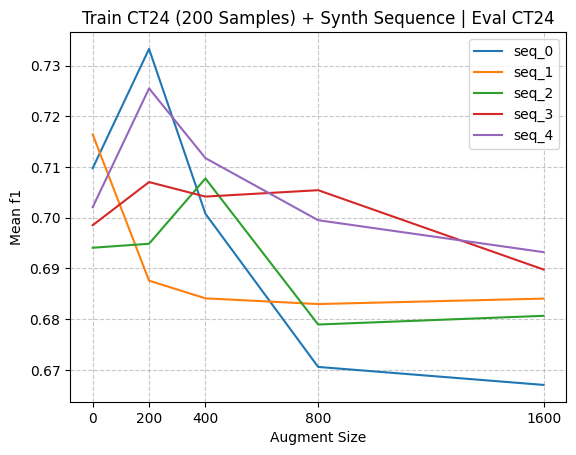

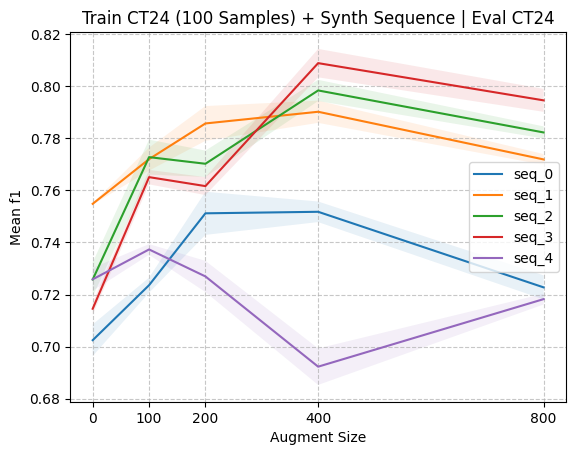

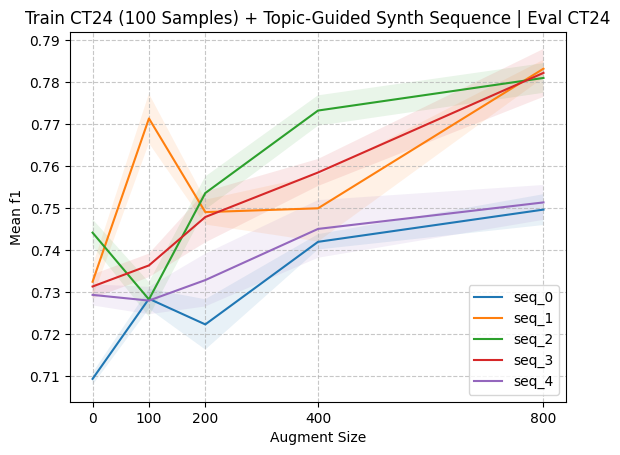

In [17]:
eval_groups = [
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_gc_fact_check_pos_eval",
    #         "ct24_synth_8k_2k_gc_fact_check_pos_eval",
    #         "ct24_synth_6k_4k_gc_fact_check_pos_eval",
    #         "ct24_synth_4k_6k_gc_fact_check_pos_eval",
    #         "ct24_synth_2k_8k_gc_fact_check_pos_eval",
    #         "ct24_synth_0_10k_gc_fact_check_pos_eval"
    #     ],
    #     "strip_suffix": "_gc_fact_check_pos_eval",
    #     "title": "Train CT24/Synthetic - Eval GC (Source - Fact Checks [Pos])"
    # },
    # {
    #     "runs": [
    #         "ct24_synth_10k_0_viclaim_eval",
    #         "ct24_synth_8k_2k_viclaim_eval",
    #         "ct24_synth_6k_4k_viclaim_eval",
    #         "ct24_synth_4k_6k_viclaim_eval",
    #         "ct24_synth_2k_8k_viclaim_eval",
    #         "ct24_synth_0_10k_viclaim_eval",
    #     ],
    #     "strip_suffix": "_viclaim_eval",
    #     "title": "Train CT24/Synthetic - Eval ViClaim"
    # },
    # {
    #     "runs": [
    #         "topic_split_1_topic_split_1_eval"
    #     ],
    #     "strip_suffix": "_topic_split_1_eval",
    #     "title": "Train Split 1 - Eval Split 1"
    # },
    # {
    #     "runs": [
    #         "topic_split_1_topic_split_2_eval"
    #     ],
    #     "strip_suffix": "_topic_split_2_eval",
    #     "title": "Train Split 1 - Eval Split 2"
    # },
    # {
    #     "runs": [
    #         "topic_split_2_topic_split_2_eval"
    #     ],
    #     "strip_suffix": "_topic_split_2_eval",
    #     "title": "Train Split 2 - Eval Split 2"
    # },
    # {
    #     "runs": [
    #         "topic_split_2_topic_split_1_eval"
    #     ],
    #     "strip_suffix": "_topic_split_1_eval",
    #     "title": "Train Split 2 - Eval Split 1"
    # },
    {
        "runs": [
            {"run_names": "topic_separation_fiscal_topic_separation_fiscal_eval", "plot_name": "fiscal"},
            {"run_names": "topic_separation_security_topic_separation_fiscal_eval", "plot_name": "security"},
            {"run_names": "topic_separation_government_topic_separation_fiscal_eval", "plot_name": "government"},
        ],
        "title": "Eval Fiscal"
    },
    {
        "runs": [
            {"run_names": "topic_separation_fiscal_topic_separation_security_eval", "plot_name": "fiscal"},
            {"run_names": "topic_separation_security_topic_separation_security_eval", "plot_name": "security"},
            {"run_names": "topic_separation_government_topic_separation_security_eval", "plot_name": "government"},
        ],
        "title": "Eval Security"
    },
    {
        "runs": [
            {"run_names": "topic_separation_fiscal_topic_separation_government_eval", "plot_name": "fiscal"},
            {"run_names": "topic_separation_security_topic_separation_government_eval", "plot_name": "security"},
            {"run_names": "topic_separation_government_topic_separation_government_eval", "plot_name": "government"},
        ],
        "title": "Eval Government"
    },
    # {
    #     "runs": [
    #         "fiscal_synth_2.6k_5_0_topic_separation_fiscal_eval",
    #         "fiscal_synth_2.6k_4_1_topic_separation_fiscal_eval",
    #         "fiscal_synth_2.6k_3_2_topic_separation_fiscal_eval",
    #         "fiscal_synth_2.6k_2_3_topic_separation_fiscal_eval",
    #         "fiscal_synth_2.6k_1_4_topic_separation_fiscal_eval",
    #         "fiscal_synth_2.6k_0_5_topic_separation_fiscal_eval",
    #     ],
    #     "strip_suffix": "_topic_separation_fiscal_eval",
    #     "title": "Train Fiscal/Synth - Eval Fiscal"
    # },
    # {
    #     "runs": [
    #         "security_synth_2.6k_5_0_topic_separation_fiscal_eval",
    #         "security_synth_2.6k_4_1_topic_separation_fiscal_eval",
    #         "security_synth_2.6k_3_2_topic_separation_fiscal_eval",
    #         "security_synth_2.6k_2_3_topic_separation_fiscal_eval",
    #         "security_synth_2.6k_1_4_topic_separation_fiscal_eval",
    #         "security_synth_2.6k_0_5_topic_separation_fiscal_eval",
    #     ],
    #     "strip_suffix": "_topic_separation_fiscal_eval",
    #     "title": "Train Security/Synth - Eval Fiscal"
    # },
    # {
    #     "runs": [
    #         "government_synth_2.6k_5_0_topic_separation_fiscal_eval",
    #         "government_synth_2.6k_4_1_topic_separation_fiscal_eval",
    #         "government_synth_2.6k_3_2_topic_separation_fiscal_eval",
    #         "government_synth_2.6k_2_3_topic_separation_fiscal_eval",
    #         "government_synth_2.6k_1_4_topic_separation_fiscal_eval",
    #         "government_synth_2.6k_0_5_topic_separation_fiscal_eval",
    #     ],
    #     "strip_suffix": "_topic_separation_fiscal_eval",
    #     "title": "Train Government/Synth - Eval Fiscal"
    # },
    {
        "runs": [
            {"run_names": "fiscal_synth_security_2.6k_5_0_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_security_100%_0%"},
            {"run_names": "fiscal_synth_security_2.6k_4_1_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_security_80%_20%"},
            {"run_names": "fiscal_synth_security_2.6k_3_2_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_security_60%_40%"},
            {"run_names": "fiscal_synth_security_2.6k_2_3_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_security_40%_60%"},
            {"run_names": "fiscal_synth_security_2.6k_1_4_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_security_20%_80%"},
            {"run_names": "fiscal_synth_security_2.6k_0_5_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_security_0%_100%"},
        ],
        "title": "Train Fiscal/Synth-Security | Eval Fiscal"
    },
    {
        "runs": [
            {"run_names": "fiscal_synth_government_2.6k_5_0_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_government_100%_0%"},
            {"run_names": "fiscal_synth_government_2.6k_4_1_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_government_80%_20%"},
            {"run_names": "fiscal_synth_government_2.6k_3_2_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_government_60%_40%"},
            {"run_names": "fiscal_synth_government_2.6k_2_3_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_government_40%_60%"},
            {"run_names": "fiscal_synth_government_2.6k_1_4_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_government_20%_80%"},
            {"run_names": "fiscal_synth_government_2.6k_0_5_topic_separation_fiscal_eval", "plot_name": "fiscal_synth_government_0%_100%"},
        ],
        "title": "Train Fiscal/Synth-Government | Eval Fiscal"
    },
    {
        "runs": [
            {"run_names": "government_synth_fiscal_2.6k_5_0_topic_separation_fiscal_eval", "plot_name": "government_synth_fiscal_100%_0%"},
            {"run_names": "government_synth_fiscal_2.6k_4_1_topic_separation_fiscal_eval", "plot_name": "government_synth_fiscal_80%_20%"},
            {"run_names": "government_synth_fiscal_2.6k_3_2_topic_separation_fiscal_eval", "plot_name": "government_synth_fiscal_60%_40%"},
            {"run_names": "government_synth_fiscal_2.6k_2_3_topic_separation_fiscal_eval", "plot_name": "government_synth_fiscal_40%_60%"},
            {"run_names": "government_synth_fiscal_2.6k_1_4_topic_separation_fiscal_eval", "plot_name": "government_synth_fiscal_20%_80%"},
            {"run_names": "government_synth_fiscal_2.6k_0_5_topic_separation_fiscal_eval", "plot_name": "government_synth_fiscal_0%_100%"},
        ],
        "title": "Train Government/Synth-Fiscal | Eval Fiscal"
    },
    {
        "runs": [
            {"run_names": "fiscal_synth_security_2.6k_5_0_topic_separation_security_eval", "plot_name": "fiscal_synth_security_100%_0%"},
            {"run_names": "fiscal_synth_security_2.6k_4_1_topic_separation_security_eval", "plot_name": "fiscal_synth_security_80%_20%"},
            {"run_names": "fiscal_synth_security_2.6k_3_2_topic_separation_security_eval", "plot_name": "fiscal_synth_security_60%_40%"},
            {"run_names": "fiscal_synth_security_2.6k_2_3_topic_separation_security_eval", "plot_name": "fiscal_synth_security_40%_60%"},
            {"run_names": "fiscal_synth_security_2.6k_1_4_topic_separation_security_eval", "plot_name": "fiscal_synth_security_20%_80%"},
            {"run_names": "fiscal_synth_security_2.6k_0_5_topic_separation_security_eval", "plot_name": "fiscal_synth_security_0%_100%"},
        ],
        "title": "Train Fiscal/Synth-Security | Eval Security"
    },
    {
        "runs": [
            {"run_names": "fiscal_synth_government_2.6k_5_0_topic_separation_security_eval", "plot_name": "fiscal_synth_government_100%_0%"},
            {"run_names": "fiscal_synth_government_2.6k_4_1_topic_separation_security_eval", "plot_name": "fiscal_synth_government_80%_20%"},
            {"run_names": "fiscal_synth_government_2.6k_3_2_topic_separation_security_eval", "plot_name": "fiscal_synth_government_60%_40%"},
            {"run_names": "fiscal_synth_government_2.6k_2_3_topic_separation_security_eval", "plot_name": "fiscal_synth_government_40%_60%"},
            {"run_names": "fiscal_synth_government_2.6k_1_4_topic_separation_security_eval", "plot_name": "fiscal_synth_government_20%_80%"},
            {"run_names": "fiscal_synth_government_2.6k_0_5_topic_separation_security_eval", "plot_name": "fiscal_synth_government_0%_100%"},
        ],
        "title": "Train Fiscal/Synth-Government | Eval Security"
    },
    {
        "runs": [
            {"run_names": "government_synth_fiscal_2.6k_5_0_topic_separation_security_eval", "plot_name": "government_synth_fiscal_100%_0%"},
            {"run_names": "government_synth_fiscal_2.6k_4_1_topic_separation_security_eval", "plot_name": "government_synth_fiscal_80%_20%"},
            {"run_names": "government_synth_fiscal_2.6k_3_2_topic_separation_security_eval", "plot_name": "government_synth_fiscal_60%_40%"},
            {"run_names": "government_synth_fiscal_2.6k_2_3_topic_separation_security_eval", "plot_name": "government_synth_fiscal_40%_60%"},
            {"run_names": "government_synth_fiscal_2.6k_1_4_topic_separation_security_eval", "plot_name": "government_synth_fiscal_20%_80%"},
            {"run_names": "government_synth_fiscal_2.6k_0_5_topic_separation_security_eval", "plot_name": "government_synth_fiscal_0%_100%"},
        ],
        "title": "Train Government/Synth-Fiscal | Eval Security"
    },
    {
        "runs": [
            {"run_names": "fiscal_synth_security_2.6k_5_0_topic_separation_government_eval", "plot_name": "fiscal_synth_security_100%_0%"},
            {"run_names": "fiscal_synth_security_2.6k_4_1_topic_separation_government_eval", "plot_name": "fiscal_synth_security_80%_20%"},
            {"run_names": "fiscal_synth_security_2.6k_3_2_topic_separation_government_eval", "plot_name": "fiscal_synth_security_60%_40%"},
            {"run_names": "fiscal_synth_security_2.6k_2_3_topic_separation_government_eval", "plot_name": "fiscal_synth_security_40%_60%"},
            {"run_names": "fiscal_synth_security_2.6k_1_4_topic_separation_government_eval", "plot_name": "fiscal_synth_security_20%_80%"},
            {"run_names": "fiscal_synth_security_2.6k_0_5_topic_separation_government_eval", "plot_name": "fiscal_synth_security_0%_100%"},
        ],
        "title": "Train Fiscal/Synth-Security | Eval Government"
    },
    {
        "runs": [
            {"run_names": "fiscal_synth_government_2.6k_5_0_topic_separation_government_eval", "plot_name": "fiscal_synth_government_100%_0%"},
            {"run_names": "fiscal_synth_government_2.6k_4_1_topic_separation_government_eval", "plot_name": "fiscal_synth_government_80%_20%"},
            {"run_names": "fiscal_synth_government_2.6k_3_2_topic_separation_government_eval", "plot_name": "fiscal_synth_government_60%_40%"},
            {"run_names": "fiscal_synth_government_2.6k_2_3_topic_separation_government_eval", "plot_name": "fiscal_synth_government_40%_60%"},
            {"run_names": "fiscal_synth_government_2.6k_1_4_topic_separation_government_eval", "plot_name": "fiscal_synth_government_20%_80%"},
            {"run_names": "fiscal_synth_government_2.6k_0_5_topic_separation_government_eval", "plot_name": "fiscal_synth_government_0%_100%"},
        ],
        "title": "Train Fiscal/Synth-Government | Eval Government"
    },
    {
        "runs": [
            {"run_names": "government_synth_fiscal_2.6k_5_0_topic_separation_government_eval", "plot_name": "government_synth_fiscal_100%_0%"},
            {"run_names": "government_synth_fiscal_2.6k_4_1_topic_separation_government_eval", "plot_name": "government_synth_fiscal_80%_20%"},
            {"run_names": "government_synth_fiscal_2.6k_3_2_topic_separation_government_eval", "plot_name": "government_synth_fiscal_60%_40%"},
            {"run_names": "government_synth_fiscal_2.6k_2_3_topic_separation_government_eval", "plot_name": "government_synth_fiscal_40%_60%"},
            {"run_names": "government_synth_fiscal_2.6k_1_4_topic_separation_government_eval", "plot_name": "government_synth_fiscal_20%_80%"},
            {"run_names": "government_synth_fiscal_2.6k_0_5_topic_separation_government_eval", "plot_name": "government_synth_fiscal_0%_100%"},
        ],
        "title": "Train Government/Synth-Fiscal | Eval Government"
    },
    {
        "runs": [
            {"run_names": "ct24_synth_corona_2.6k_0k", "plot_name": "ct24_synth_covid_100%_0%"},
            {"run_names": "ct24_synth_corona_2.1k_0.5k", "plot_name": "ct24_synth_covid_80%_20%"},
            {"run_names": "ct24_synth_corona_1.6k_1.0k", "plot_name": "ct24_synth_covid_60%_40%"},
            {"run_names": "ct24_synth_corona_1.0k_1.6k", "plot_name": "ct24_synth_covid_40%_60%"},
            {"run_names": "ct24_synth_corona_0.5k_2.1k", "plot_name": "ct24_synth_covid_20%_80%"},
            {"run_names": "ct24_synth_corona_0k_2.6k", "plot_name": "ct24_synth_covid_0%_100%"},
        ],
        "title": "Train CT24+Synthetic-Covid | Eval CT24"
    },
    {
        "runs": [
            {"run_names": "ct21_ct22_synth_2.6k_0k_ct24_eval", "plot_name": "ct21+ct22_synth_100%_0%"},
            {"run_names": "ct21_ct22_synth_2.1k_0.5k_ct24_eval", "plot_name": "ct21+ct22_synth_80%_20%"},
            {"run_names": "ct21_ct22_synth_1.6k_1.0k_ct24_eval", "plot_name": "ct21+ct22_synth_60%_40%"},
            {"run_names": "ct21_ct22_synth_1.0k_1.6k_ct24_eval", "plot_name": "ct21+ct22_synth_40%_60%"},
            {"run_names": "ct21_ct22_synth_0.5k_2.1k_ct24_eval", "plot_name": "ct21+ct22_synth_20%_80%"},
            {"run_names": "ct21_ct22_synth_0k_2.6k_ct24_eval", "plot_name": "ct21+ct22_synth_0%_100%"},
        ],
        "title": "Train CT21+CT22+Synthetic | Eval CT24"
    },
    {
        "runs": [
            {"run_names": "ct24_synth_corona_2.6k_0k_ct21_ct22_eval", "plot_name": "ct24_synth_covid_100%_0%"},
            {"run_names": "ct24_synth_corona_2.1k_0.5k_ct21_ct22_eval", "plot_name": "ct24_synth_covid_80%_20%"},
            {"run_names": "ct24_synth_corona_1.6k_1.0k_ct21_ct22_eval", "plot_name": "ct24_synth_covid_60%_40%"},
            {"run_names": "ct24_synth_corona_1.0k_1.6k_ct21_ct22_eval", "plot_name": "ct24_synth_covid_40%_60%"},
            {"run_names": "ct24_synth_corona_0.5k_2.1k_ct21_ct22_eval", "plot_name": "ct24_synth_covid_20%_80%"},
            {"run_names": "ct24_synth_corona_0k_2.6k_ct21_ct22_eval", "plot_name": "ct24_synth_covid_0%_100%"},
        ],
        "title": "Train CT24+Synthetic-Covid | Eval CT21+CT22"
    },
    {
        "runs": [
            {"run_names": "ct21_ct22_synth_2.6k_0k", "plot_name": "ct21+ct22_synth_100%_0%"},
            {"run_names": "ct21_ct22_synth_2.1k_0.5k", "plot_name": "ct21+ct22_synth_80%_20%"},
            {"run_names": "ct21_ct22_synth_1.6k_1.0k", "plot_name": "ct21+ct22_synth_60%_40%"},
            {"run_names": "ct21_ct22_synth_1.0k_1.6k", "plot_name": "ct21+ct22_synth_40%_60%"},
            {"run_names": "ct21_ct22_synth_0.5k_2.1k", "plot_name": "ct21+ct22_synth_20%_80%"},
            {"run_names": "ct21_ct22_synth_0k_2.6k", "plot_name": "ct21+ct22_synth_0%_100%"},
        ],
        "title": "Train CT21+CT22/Synthetic-Covid | Eval CT21+CT22"
    },
    {
        "runs": [
            {"run_names": "train_wo_security_synth_security_5_0_topic_separation_security_eval", "plot_name": "ct24_wo_sec_synth_sec_100%_0%"},
            {"run_names": "train_wo_security_synth_security_4_1_topic_separation_security_eval", "plot_name": "ct24_wo_sec_synth_sec_80%_20%"},
        ],
        "title": "Train CT24 w/o security+Synthetic-Security | Eval Security"
    },
    {
        "runs": [
            {"run_names": ("ct24_seq_0_size_156", "ct24_seq_1_size_156", "ct24_seq_2_size_156"), "plot_name": "ct24_156"},
            {"run_names": ("ct24_seq_0_size_312", "ct24_seq_1_size_312", "ct24_seq_2_size_312"), "plot_name": "ct24_312"},
            {"run_names": ("ct24_seq_0_size_625", "ct24_seq_1_size_625", "ct24_seq_2_size_625"), "plot_name": "ct24_625"},
            {"run_names": ("ct24_seq_0_size_1250", "ct24_seq_1_size_1250", "ct24_seq_2_size_1250"), "plot_name": "ct24_1250"},
            {"run_names": ("ct24_seq_0_size_2500", "ct24_seq_1_size_2500", "ct24_seq_2_size_2500"), "plot_name": "ct24_2500"},
            {"run_names": ("ct24_seq_0_size_5000", "ct24_seq_1_size_5000", "ct24_seq_2_size_5000"), "plot_name": "ct24_5000"},
        ],
        "title": "Train CT24 Sequence | Eval CT24"
    },
    {
        "runs": [
            {"run_names": ("ct24_synth_seq_0_size_156", "ct24_synth_seq_1_size_156", "ct24_synth_seq_2_size_156"), "plot_name": "ct24_synth_156"},
            {"run_names": ("ct24_synth_seq_0_size_312", "ct24_synth_seq_1_size_312", "ct24_synth_seq_2_size_312"), "plot_name": "ct24_synth_312"},
            {"run_names": ("ct24_synth_seq_0_size_625", "ct24_synth_seq_1_size_625", "ct24_synth_seq_2_size_625"), "plot_name": "ct24_synth_625"},
            {"run_names": ("ct24_synth_seq_0_size_1250", "ct24_synth_seq_1_size_1250", "ct24_synth_seq_2_size_1250"), "plot_name": "ct24_synth_1250"},
            {"run_names": ("ct24_synth_seq_0_size_2500", "ct24_synth_seq_1_size_2500", "ct24_synth_seq_2_size_2500"), "plot_name": "ct24_synth_2500"},
            {"run_names": ("ct24_synth_seq_0_size_5000", "ct24_synth_seq_1_size_5000", "ct24_synth_seq_2_size_5000"), "plot_name": "ct24_synth_5000"},
        ],
        "title": "Train CT24 Sequence + Synth | Eval CT24"
    },
    {
        "runs": [
            {"run_names": "ct24_200", "plot_name": "ct24_200"},
            {"run_names": "ct24_synth_200_200", "plot_name": "ct24_200_synth_200"},
            {"run_names": "ct24_synth_200_400", "plot_name": "ct24_200_synth_400"},
            {"run_names": "ct24_synth_200_800", "plot_name": "ct24_200_synth_800"},
            {"run_names": "ct24_synth_200_1600", "plot_name": "ct24_200_synth_1600"},
        ],
        "title": "Train CT24 + Synth Sequence | Eval CT24",
    }
]
#runs_to_f1_stripplots(eval_groups, load_from_cache=True)

seq_groups = [
    {
        "sequences": [
            {"run_names": ("ct24_200_synth_seq_0_0_combined_eval", "ct24_200_synth_seq_0_200_combined_eval", "ct24_200_synth_seq_0_400_combined_eval", "ct24_200_synth_seq_0_800_combined_eval", "ct24_200_synth_seq_0_1600_combined_eval"), "plot_name": "seq_0"},
            {"run_names": ("ct24_200_synth_seq_1_0_combined_eval", "ct24_200_synth_seq_1_200_combined_eval", "ct24_200_synth_seq_1_400_combined_eval", "ct24_200_synth_seq_1_800_combined_eval", "ct24_200_synth_seq_1_1600_combined_eval"), "plot_name": "seq_1"},
            {"run_names": ("ct24_200_synth_seq_2_0_combined_eval", "ct24_200_synth_seq_2_200_combined_eval", "ct24_200_synth_seq_2_400_combined_eval", "ct24_200_synth_seq_2_800_combined_eval", "ct24_200_synth_seq_2_1600_combined_eval"), "plot_name": "seq_2"},
            {"run_names": ("ct24_200_synth_seq_3_0_combined_eval", "ct24_200_synth_seq_3_200_combined_eval", "ct24_200_synth_seq_3_400_combined_eval", "ct24_200_synth_seq_3_800_combined_eval", "ct24_200_synth_seq_3_1600_combined_eval"), "plot_name": "seq_3"},
            {"run_names": ("ct24_200_synth_seq_4_0_combined_eval", "ct24_200_synth_seq_4_200_combined_eval", "ct24_200_synth_seq_4_400_combined_eval", "ct24_200_synth_seq_4_800_combined_eval", "ct24_200_synth_seq_4_1600_combined_eval"), "plot_name": "seq_4"},
        ],
        "title": "Train CT24 (200 Samples) + Synth Sequence | Eval CT24",
        "sizes": np.array([0, 200, 400, 800, 1600]),
        "x-label": "Augment Size",
        "std_scale": 0.0
    },
    {
        "sequences": [
            {"run_names": ("experiment_001_seq_0_aug_0", "experiment_001_seq_0_aug_100", "experiment_001_seq_0_aug_200", "experiment_001_seq_0_aug_400", "experiment_001_seq_0_aug_800"), "plot_name": "seq_0"},
            {"run_names": ("experiment_001_seq_1_aug_0", "experiment_001_seq_1_aug_100", "experiment_001_seq_1_aug_200", "experiment_001_seq_1_aug_400", "experiment_001_seq_1_aug_800"), "plot_name": "seq_1"},
            {"run_names": ("experiment_001_seq_2_aug_0", "experiment_001_seq_2_aug_100", "experiment_001_seq_2_aug_200", "experiment_001_seq_2_aug_400", "experiment_001_seq_2_aug_800"), "plot_name": "seq_2"},
            {"run_names": ("experiment_001_seq_3_aug_0", "experiment_001_seq_3_aug_100", "experiment_001_seq_3_aug_200", "experiment_001_seq_3_aug_400", "experiment_001_seq_3_aug_800"), "plot_name": "seq_3"},
            {"run_names": ("experiment_001_seq_4_aug_0", "experiment_001_seq_4_aug_100", "experiment_001_seq_4_aug_200", "experiment_001_seq_4_aug_400", "experiment_001_seq_4_aug_800"), "plot_name": "seq_4"},
        ],
        "title": "Train CT24 (100 Samples) + Synth Sequence | Eval CT24",
        "sizes": np.array([0, 100, 200, 400, 800]),
        "x-label": "Augment Size",
        "std_scale": 0.25
    },
    {
        "sequences": [
            {"run_names": ("experiment_002_seq_0_aug_0", "experiment_002_seq_0_aug_100", "experiment_002_seq_0_aug_200", "experiment_002_seq_0_aug_400", "experiment_002_seq_0_aug_800"), "plot_name": "seq_0"},
            {"run_names": ("experiment_002_seq_1_aug_0", "experiment_002_seq_1_aug_100", "experiment_002_seq_1_aug_200", "experiment_002_seq_1_aug_400", "experiment_002_seq_1_aug_800"), "plot_name": "seq_1"},
            {"run_names": ("experiment_002_seq_2_aug_0", "experiment_002_seq_2_aug_100", "experiment_002_seq_2_aug_200", "experiment_002_seq_2_aug_400", "experiment_002_seq_2_aug_800"), "plot_name": "seq_2"},
            {"run_names": ("experiment_002_seq_3_aug_0", "experiment_002_seq_3_aug_100", "experiment_002_seq_3_aug_200", "experiment_002_seq_3_aug_400", "experiment_002_seq_3_aug_800"), "plot_name": "seq_3"},
            {"run_names": ("experiment_002_seq_4_aug_0", "experiment_002_seq_4_aug_100", "experiment_002_seq_4_aug_200", "experiment_002_seq_4_aug_400", "experiment_002_seq_4_aug_800"), "plot_name": "seq_4"},
        ],
        "title": "Train CT24 (100 Samples) + Topic-Guided Synth Sequence | Eval CT24",
        "sizes": np.array([0, 100, 200, 400, 800]),
        "x-label": "Augment Size",
        "std_scale": 0.25
    },
]

runs_to_linegraphs(seq_groups, metric="f1", load_from_cache=True)

# Check out single sequence
eval_groups = [
    {
        "runs": [
            {"run_names": "ct24_200_synth_seq_4_0", "plot_name": "synth 0"},
            {"run_names": "ct24_200_synth_seq_4_200", "plot_name": "synth 200"},
            {"run_names": "ct24_200_synth_seq_4_400", "plot_name": "synth 400"},
            {"run_names": "ct24_200_synth_seq_4_800", "plot_name": "synth 800"},
            {"run_names": "ct24_200_synth_seq_4_1600", "plot_name": "synth 1600"},
        ],
        "title": "Train CT24 + Synth Sequence 4 | Eval CT24",
    }
]
#runs_to_f1_stripplots(eval_groups, load_from_cache=True)

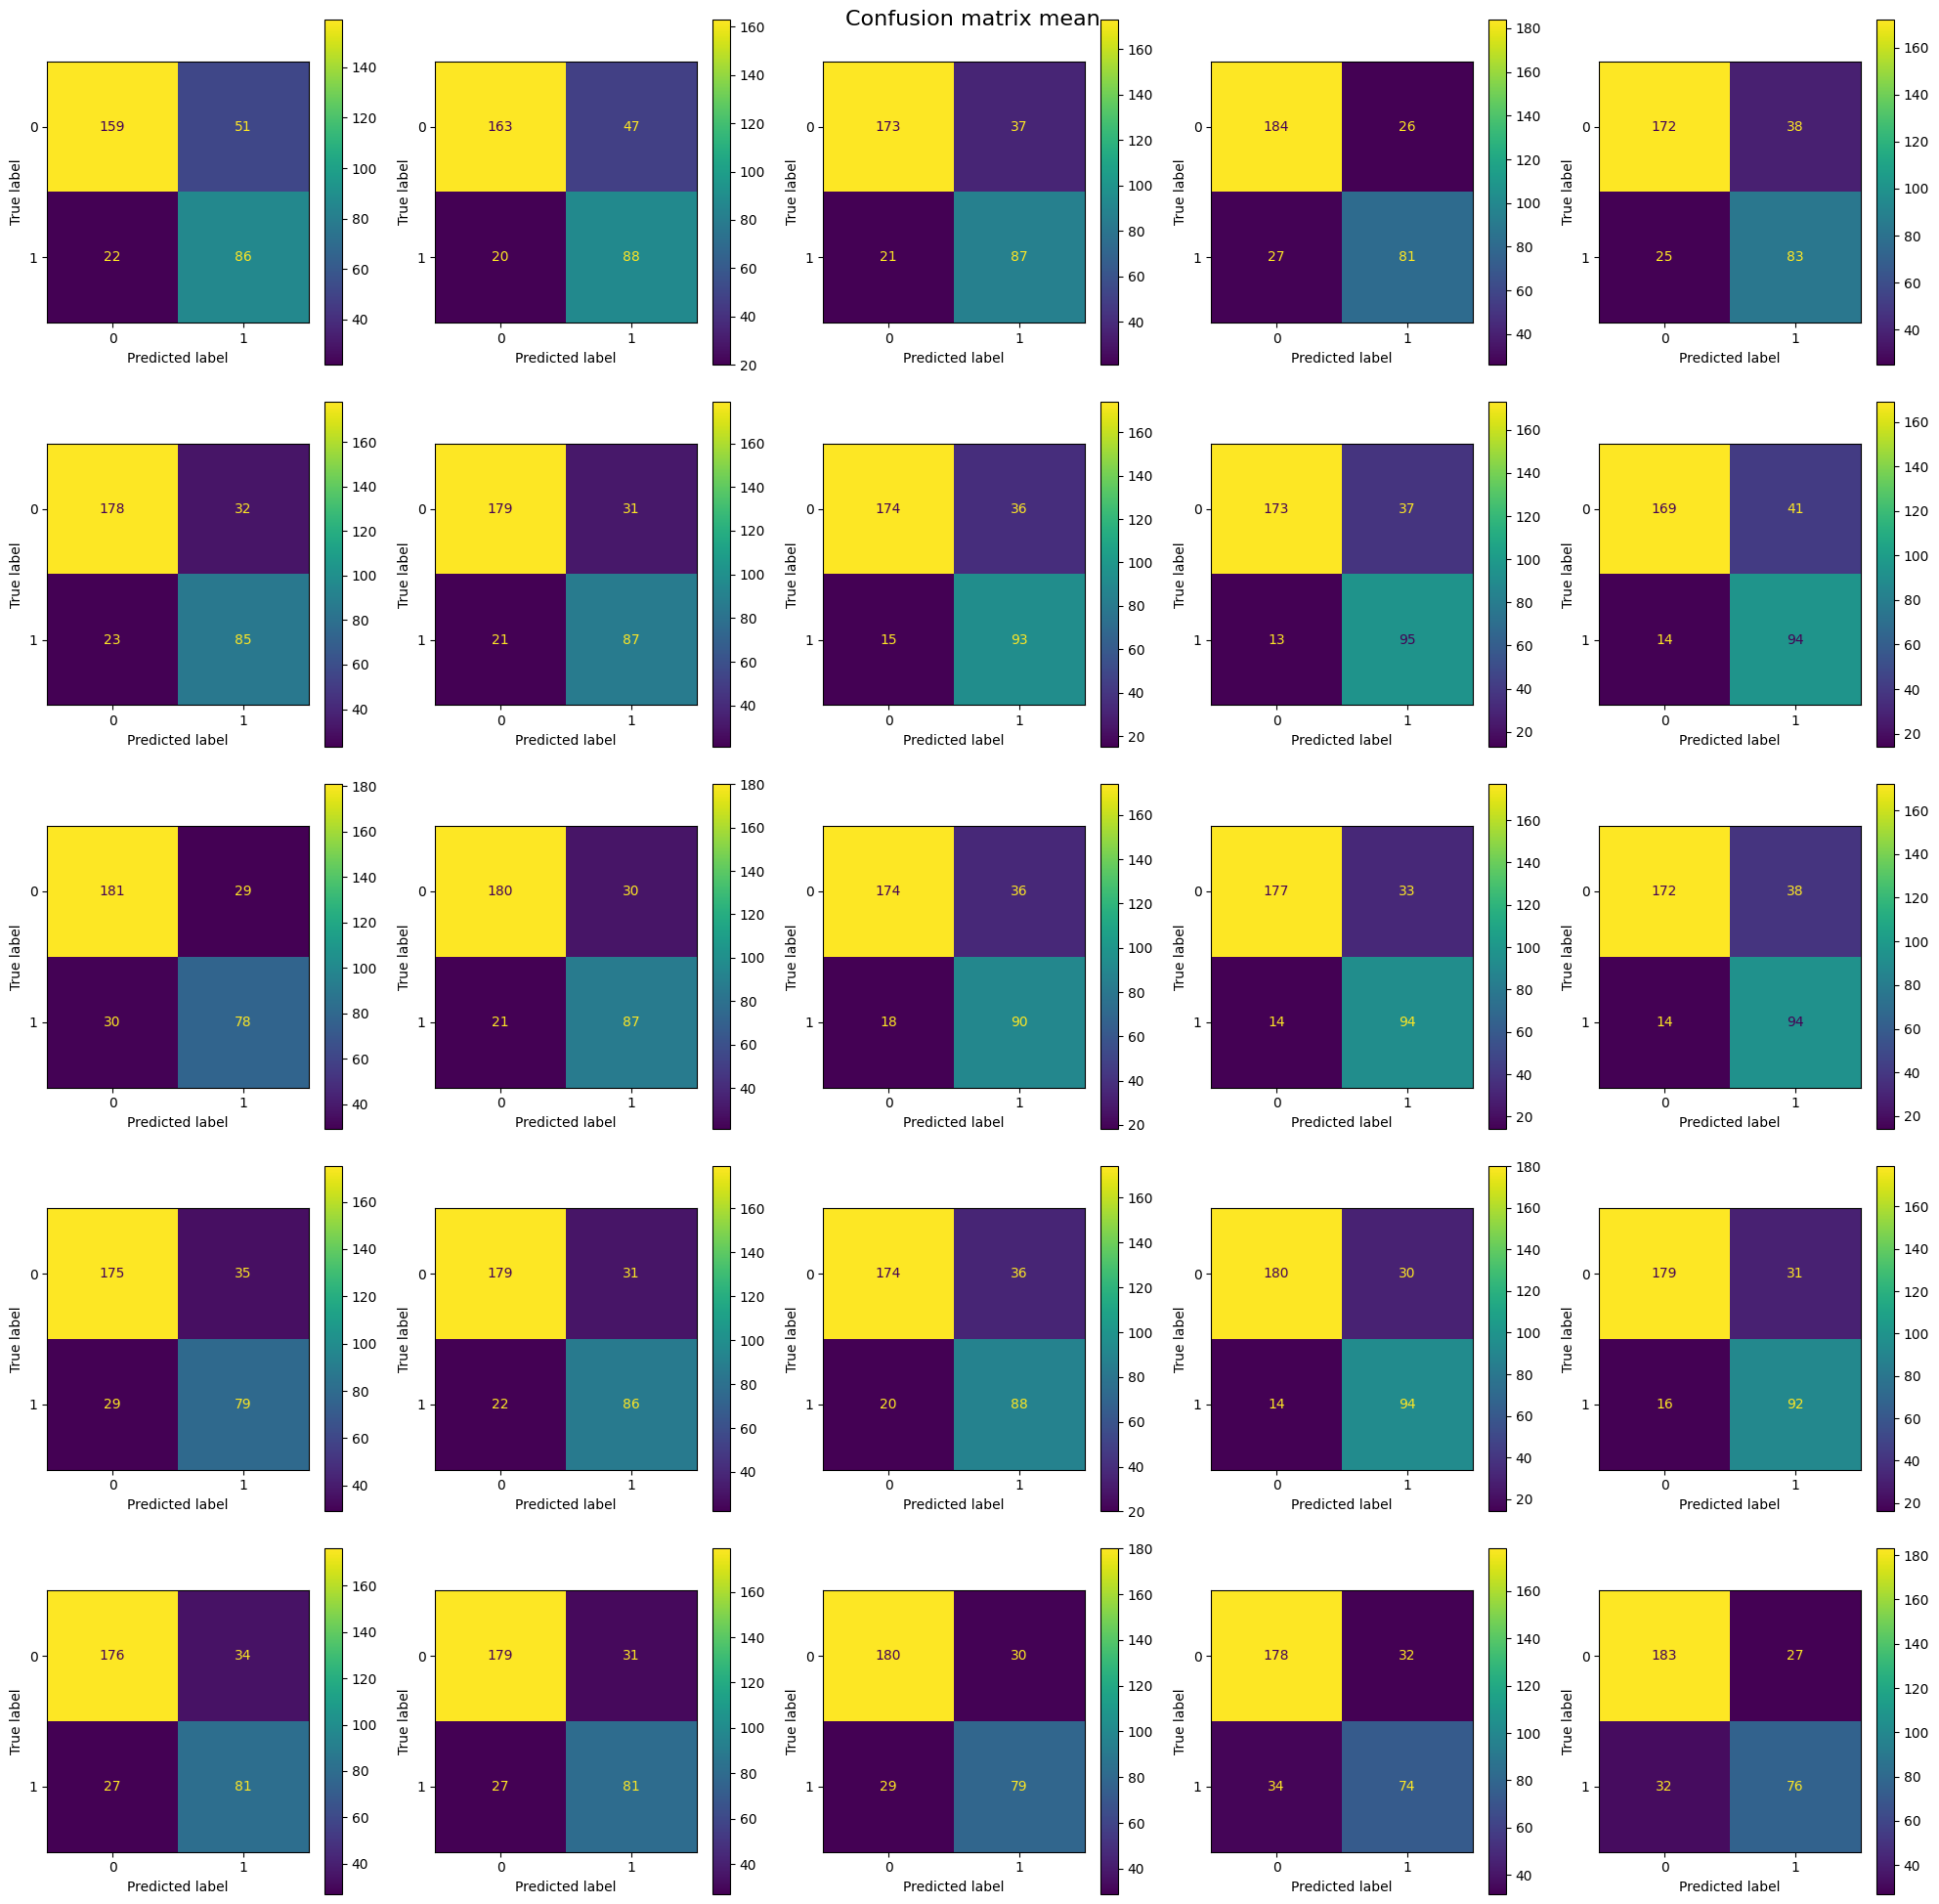

In [18]:
plot_sequence_conf_mats(seq_groups[1]["sequences"], use_cached=True)

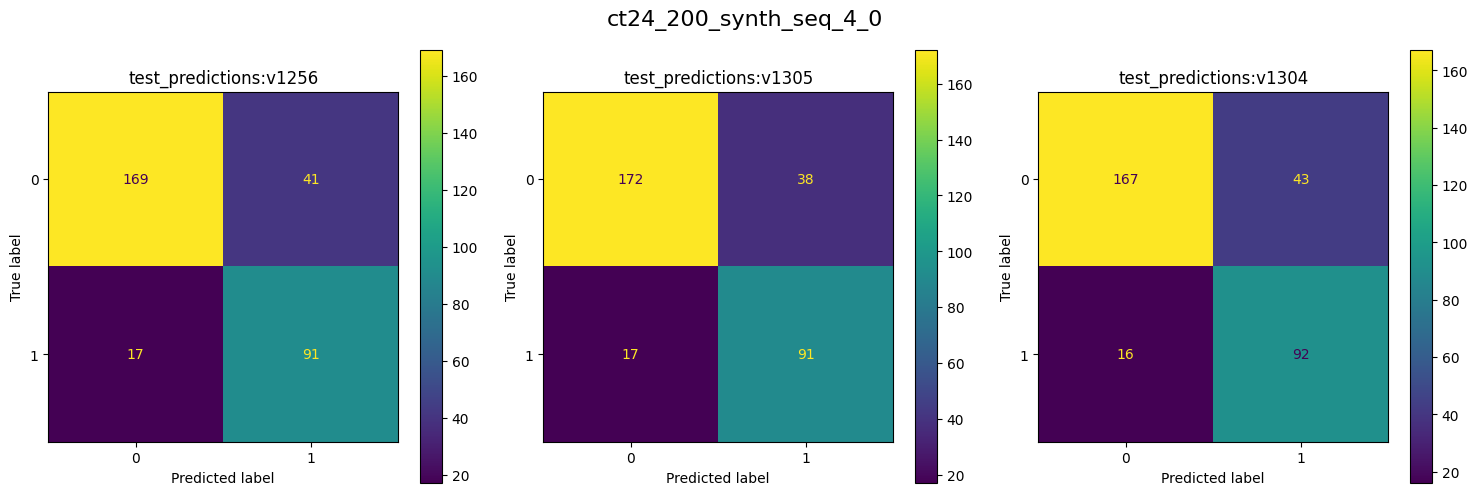

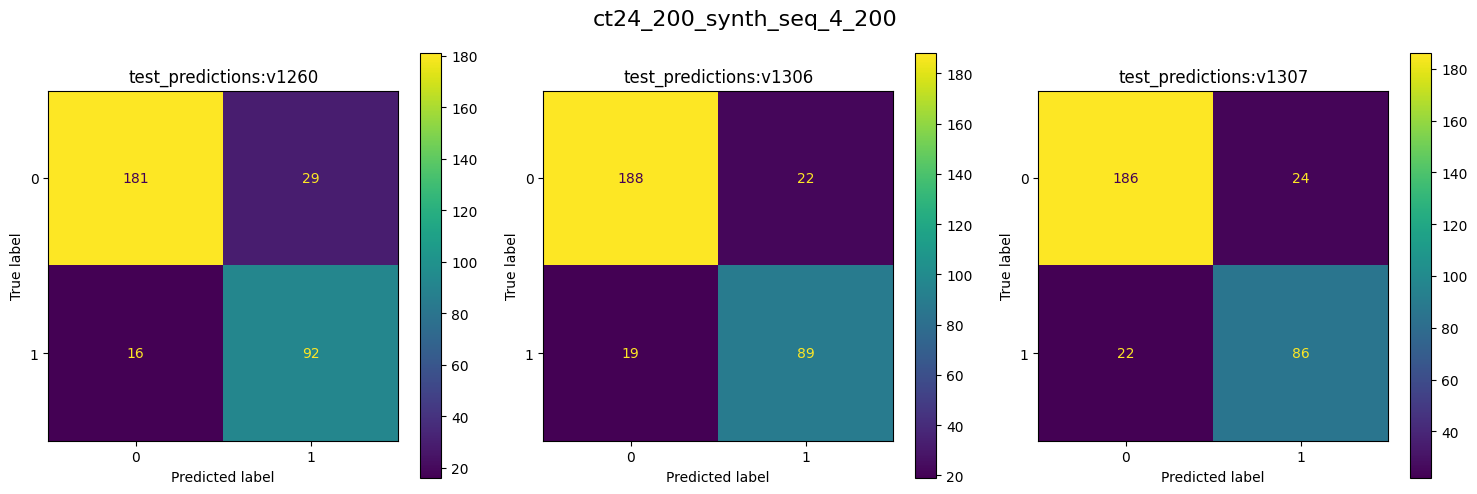

In [25]:
plot_predictions(download_predictions("ct24_200_synth_seq_4_0", use_cached=True))
plot_predictions(download_predictions("ct24_200_synth_seq_4_200", use_cached=True))

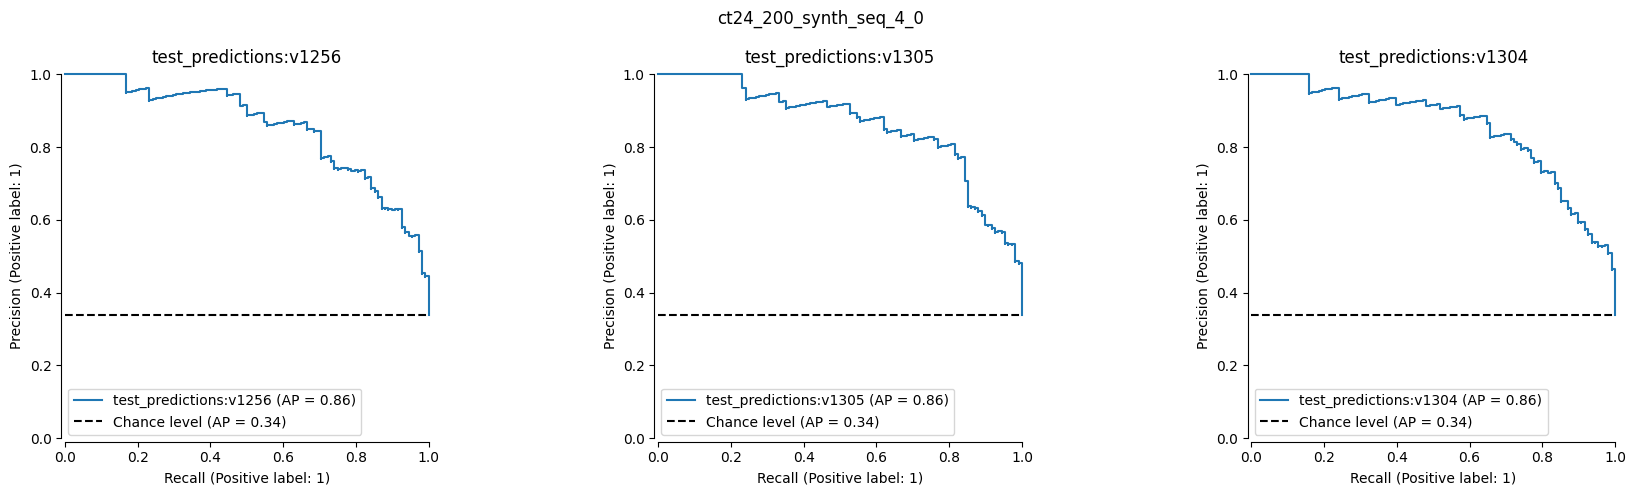

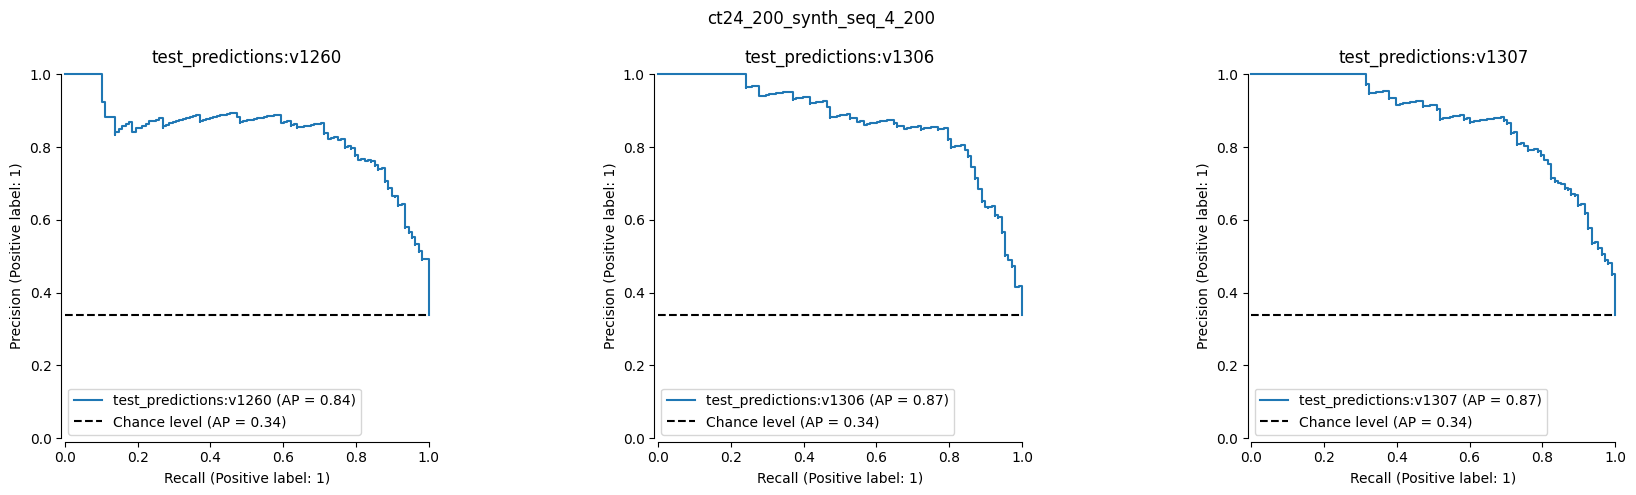

In [26]:
plot_precision_recall_curve("ct24_200_synth_seq_4_0", use_cache=True)
plot_precision_recall_curve("ct24_200_synth_seq_4_200", use_cache=True)

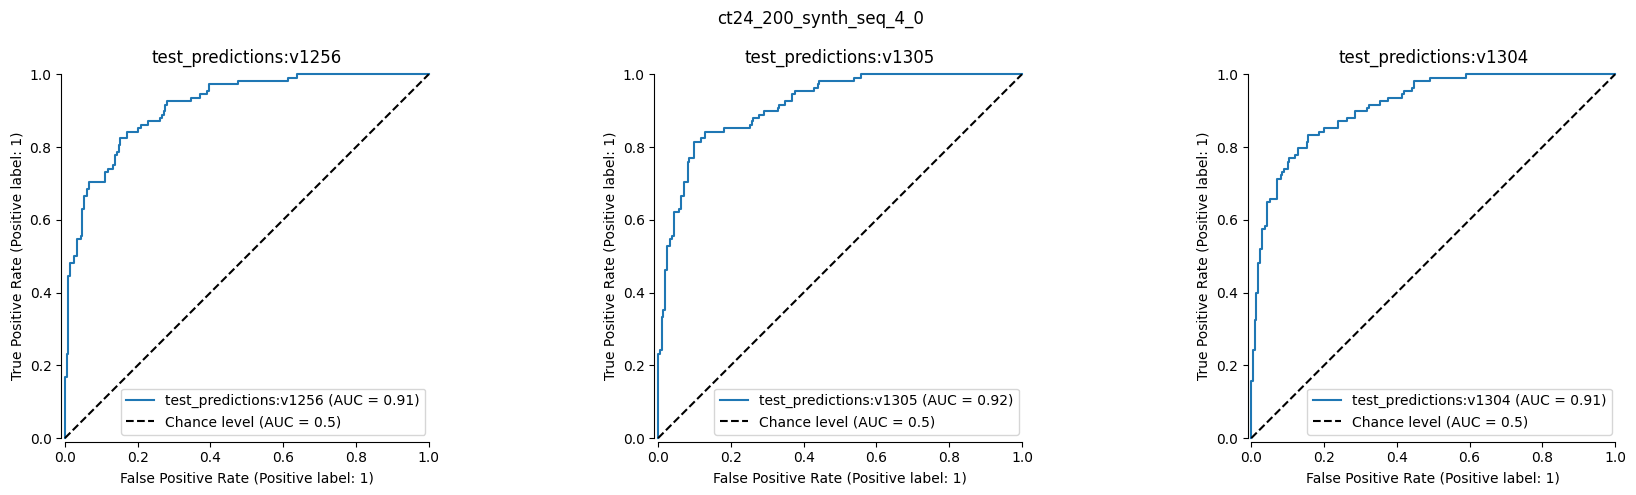

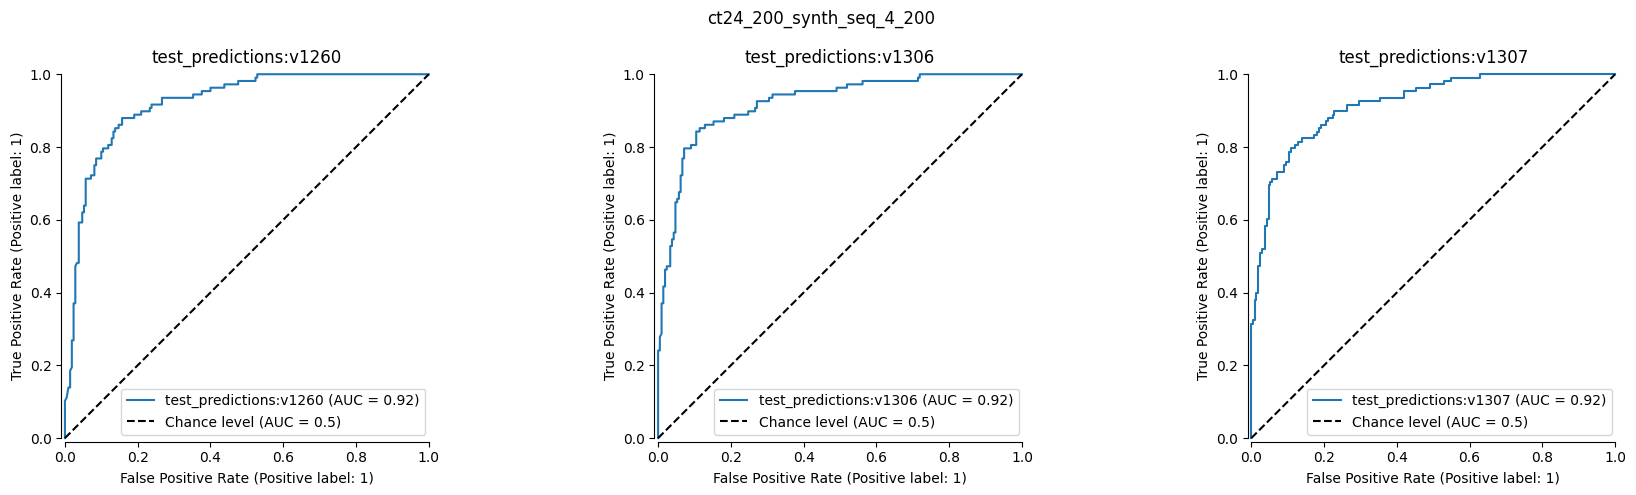

In [27]:
plot_roc_curve("ct24_200_synth_seq_4_0", use_cache=True)
plot_roc_curve("ct24_200_synth_seq_4_200", use_cache=True)

In [ ]:
synth_eval = download_predictions("ct24_synth_200_400", use_cached=True)
ct24_eval = download_predictions("ct24_200", use_cached=True)

In [ ]:
synth_eval_misclass = intersect_misclassifications(misclassified=[get_misclassified_samples(predictions=d['predictions'], data_frame=d['test_set']) for d in synth_eval], min_num_misclassified=3)
ct24_eval_misclass = intersect_misclassifications(misclassified=[get_misclassified_samples(predictions=d['predictions'], data_frame=d['test_set']) for d in ct24_eval], min_num_misclassified=3)

In [ ]:
ct24_excl, synth_excl = exclusive_misclassifications(ct24_eval_misclass, synth_eval_misclass)

In [ ]:
synth_excl